# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Define method for CUR decomposition

In [22]:
def cur(A, idx=False, SVD=None, rank=None):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M): # row/column selection method
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt))
    C = A[:,p_C]
    
    p_R = DEIM(V)
    R = A[p_R]
    
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,U,R, p_C, p_R) if idx else (C,U,R)

# Load survey data

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel(path, sheet_name="Survey_32W", converters={'T1':str, 'T3':str, 'T4':str}, na_filter=False)

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T4'] != '') &
    (survey_32W['T4'] != 'None.') &
    (survey_32W['T4'] != 'none') &
    (survey_32W['T4'] != 'N/A') &
    (survey_32W['T4'] != 'No comments') &
    (survey_32W['T4'] != 'NO COMMENTS MADE') &
    (survey_32W['T4'] != 'None') &
    (survey_32W['T4'] != 'no comments') &
    (survey_32W['T4'] != 'No comments.') &
    (survey_32W['T4'] != 'I have none to make') &
    (survey_32W['T4'] != 'LEFT BLANK') &
    (survey_32W['T4'] != 'gujfujuj') &
    (survey_32W['T4'] != "I don't know any") &
    (survey_32W['T4'] != "I don't have any thing to write.") &
    (survey_32W['T4'] != 'I have nothing else to say here') &
    (survey_32W['T4'] != '[deletion][/deletion]') &
    (survey_32W['T4'] != 'None they answer themselves.') &
    (survey_32W['T4'] != '(no statement)') &
    (survey_32W['T4'] != '[unclear][/unclear]') &
    (survey_32W['T4'] != "I don't have any.") &
    (survey_32W['T4'] != '[insertion][/insertion]') &
    (survey_32W['T4'] != '---- ----') &
    (survey_32W['T4'] != 'No Comment!!!')
]

# Group by answer choice
survey_32W_same = survey_32W[survey_32W['T1'] == "['They should be together in the same outfits']"]
survey_32W_separate = survey_32W[survey_32W['T1'] == "['They should be in separate outfits']"]

# Get long responses (T4)
res_long_32W_same = survey_32W_same['T4'].tolist()
res_long_32W_separate = survey_32W_separate['T4'].tolist()

# Embedding Method: Use entire response

In [29]:
# Transpose so each column is one response embedding
embed_long_32W_same = np.transpose(model.encode(res_long_32W_same))
embed_long_32W_separate = np.transpose(model.encode(res_long_32W_separate))
embed_long_32W = np.concatenate((embed_long_32W_same, embed_long_32W_separate), axis=1)

## Plot singular values

Text(0.5, 1.0, 'Singular values of matrix of long response embeddings')

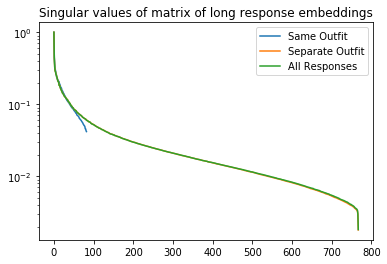

In [4]:
for A in [
    embed_long_32W_same,
    embed_long_32W_separate,
    embed_long_32W
]:
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    S = [S[i]/S[0] for i in range(len(S))]
    plt.semilogy(S)
plt.legend(["Same Outfit", "Separate Outfit", "All Responses"])
plt.title("Singular values of matrix of long response embeddings")

Note "Separate Outfit" overlaps "All Responses"

## Use CUR to form a matrix of the "most important" responses

In [30]:
C_same,U_same,R_same, p_C_same, p_R_same = cur(embed_long_32W_same, idx=True)
C_separate,U_separate,R_separate, p_C_separate, p_R_separate = cur(embed_long_32W_separate, idx=True)

## Display top 20 responses from each category

In [31]:
print("Same\n\n")
for i in range(20):
    print(res_long_32W_same[p_C_same[i]], '\n')
print("\nSeparate\n\n")
for i in range(20):
    print(res_long_32W_separate[p_C_separate[i]], '\n')

Same


This questionnaire is a fine way to let government officials know just what the "G.I." Soldier thinks. Some of the questions may have seemed unfair but when everyone states his honest opinion then something fine and outstanding will be achieved. One thing that worries me about this war is that the American people are taking victory too much for granted. May God help and make them realize that this is not a push over war. It will be won only after suffering and hardship. People should begin to realize this more every day! 

No place for a married man with 3 children in the army as man married should be home with his wife a children. not in the army. There is lot of men is not married and in the army & no 

The negro problem is one we must solve ourselves. We must raise them all to our standard of living and except [accept] them as equals or separate them in localities of their own. This is going to be a big problem in the near future and we must face it squarely. I am white but b

## Look into possible rank-k approximations

In [32]:
def plot_eta_c(A):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    sig = np.zeros(rank)
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1],S[:k+1],Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2]
        C_k, U_k, R_k, p_C_k, p_R_k = cur(A_k, idx=True, SVD=SVD_k, rank=k+1)
        
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]] #Wt?
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        
        X_k = np.linalg.pinv(C_k) @ A
        norm[k] = np.linalg.norm(A - C_k@X_k)
        
        sig[k] = np.linalg.norm(A - (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2])
        
        if k%100==0:
            print(k)
        
    plt.scatter(range(rank), eta_c)
    plt.scatter(range(rank), norm)
    plt.scatter(range(1,rank+1), sig)
    
    plt.xlabel('k')
    plt.legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])

0


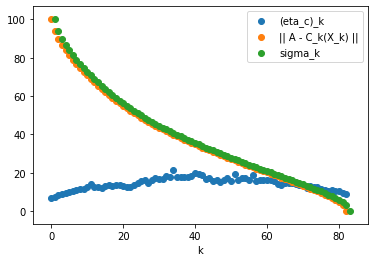

In [33]:
plot_eta_c(embed_long_32W_same)

In [ ]:
plot_eta_c(embed_long_32W_same)

# Embedding Method: Add the embeddings of each sentence in a response

In [13]:
# Transpose so each column is one response embedding
res_long_32W_same_split = [r.split(". ") for r in res_long_32W_same]
embed_long_32W_same = np.transpose([np.sum(model.encode(r), axis=0) for r in res_long_32W_same_split])

res_long_32W_separate_split = [r.split(". ") for r in res_long_32W_separate]
embed_long_32W_separate = np.transpose([np.sum(model.encode(r), axis=0) for r in res_long_32W_separate_split])

embed_long_32W = np.concatenate((embed_long_32W_same, embed_long_32W_separate), axis=1)

## Plot singular values

Text(0.5, 1.0, 'Singular values of matrix of long response embeddings')

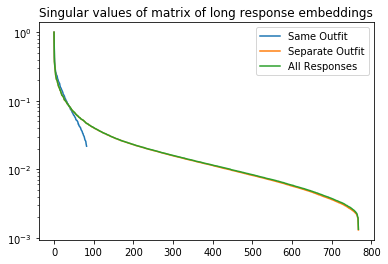

In [14]:
for A in [
    embed_long_32W_same,
    embed_long_32W_separate,
    embed_long_32W
]:
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    S = [S[i]/S[0] for i in range(len(S))]
    plt.semilogy(S)
plt.legend(["Same Outfit", "Separate Outfit", "All Responses"])
plt.title("Singular values of matrix of long response embeddings")

Note "Separate Outfit" overlaps "All Responses"

## Use CUR to form a matrix of the "most important" responses

In [23]:
C_same,U_same,R_same, p_C_same, p_R_same = cur(embed_long_32W_same, idx=True)
C_separate,U_separate,R_separate, p_C_separate, p_R_separate = cur(embed_long_32W_separate, idx=True)

## Display top 20 responses from each category

In [25]:
print("Same\n\n")
for i in range(20):
    print(res_long_32W_same[p_C_same[i]], '\n')
print("\nSeparate\n\n")
for i in range(20):
    print(res_long_32W_separate[p_C_separate[i]], '\n')

Same


This is a darn good questionnaire. I hope you can use the results to the Army's good advantage. I'm [unclear][/unclear] that this time, in this war, the administration is sincerely trying to do all possible to put our intelligent, hard fighting army in the field. [unclear][/unclear] entering the Army, I [unclear][/unclear] at the interest and ? shown in the treatment of the brick private. I hope this questionnaire is not put out by the War Department just to keep office workers busy and that they pile these up in the basement and forget them. I'm sure, however, that Mr. [unclear][/unclear] is sincere about this. 

Speaking about transportation, why must a soldier on furlough be kicked around on trains or buses. Civilians who have no place to go but are riding just to be doing something. Soldiers have stand up most of their trips on trains and eat last on dinning [dining] cars. If this question were asked each soldier, he would have plenty to say. A soldier on furlough is just a 

## Look into possible rank-k approximations

0


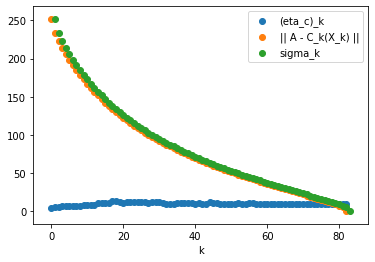

In [27]:
plot_eta_c(embed_long_32W_same)

In [34]:
plot_eta_c(embed_long_32W_separate)